In [1]:
import pandas as pd
import datetime
%matplotlib inline

In [2]:
dir_data = '../data/nba_reg18/'
ds_com = pd.DataFrame()
ds_sub = pd.DataFrame()

In [3]:
nf_subs = 7
nf_coms = 12

In [4]:
for icom in range(1, nf_subs+1):
    path_ds = dir_data + 'nba_submissions_reg18_' + str(icom) + '.csv'
    ds_cur = pd.read_csv(path_ds, index_col = 0, parse_dates = ['created'])
    ds_sub = ds_sub.append(ds_cur).drop_duplicates()

In [5]:
for icom in range(1, nf_coms+1):
    path_ds = dir_data + 'nba_comments_reg18_' + str(icom) + '.csv'
    ds_cur = pd.read_csv(path_ds, index_col = 0, parse_dates = ['created'])
    ds_com = ds_com.append(ds_cur).drop_duplicates()

In [6]:
print(ds_sub.shape)
print(ds_com.shape)

(92383, 6)
(2064767, 6)


In [7]:
team_names = pd.read_csv('teams', names = ['name', 'abbrs'])
team_dict = team_names.set_index('name').to_dict()['abbrs']
team_fulls = team_names['name'].to_list()
team_abbrs = team_names['abbrs'].to_list()

In [8]:
def flair2team(flair, team_dict, team_fulls, team_abbrs):
    # transform all flairs (team names, player names with team abbrs) into team abbrs only
    
    # team names
    for name in team_fulls:
        if name in flair:
            return team_dict[name]
    
    # player names with team abbrs
    for abbr in team_abbrs:
        if abbr in flair:
            return abbr
    
    # otherwise return original (bind into "others" later)
    return flair

In [9]:
# get rid of the weired pandas float nan
ds_com.loc[ds_com['flair'].isnull().values, 'flair'] = 'NONE'

In [10]:
ds_com['flair'] = ds_com['flair'].apply(flair2team, args = [team_dict, team_fulls, team_abbrs])

In [11]:
print(ds_com.shape)

(2064767, 6)


In [12]:
ds_com = ds_com.loc[ds_com['flair'].isin(team_abbrs), :]

In [13]:
print(ds_com.shape)

(1562342, 6)


In [14]:
# get rid of the weired pandas float nan
ds_sub.loc[ds_sub['flair'].isnull().values, 'flair'] = 'NONE'

In [15]:
ds_sub['flair'] = ds_sub['flair'].apply(flair2team, args = [team_dict, team_fulls, team_abbrs])

In [16]:
print(ds_sub.shape)

(92383, 6)


In [17]:
ds_sub = ds_sub.loc[ds_sub['flair'].isin(team_abbrs), :]

In [18]:
print(ds_sub.shape)

(55475, 6)


In [20]:
# look at comment/fan distribution
ds_comment_by_fan = ds_com.groupby(['author'])['author'].count()

In [22]:
print(ds_comment_by_fan.shape)

(66797,)


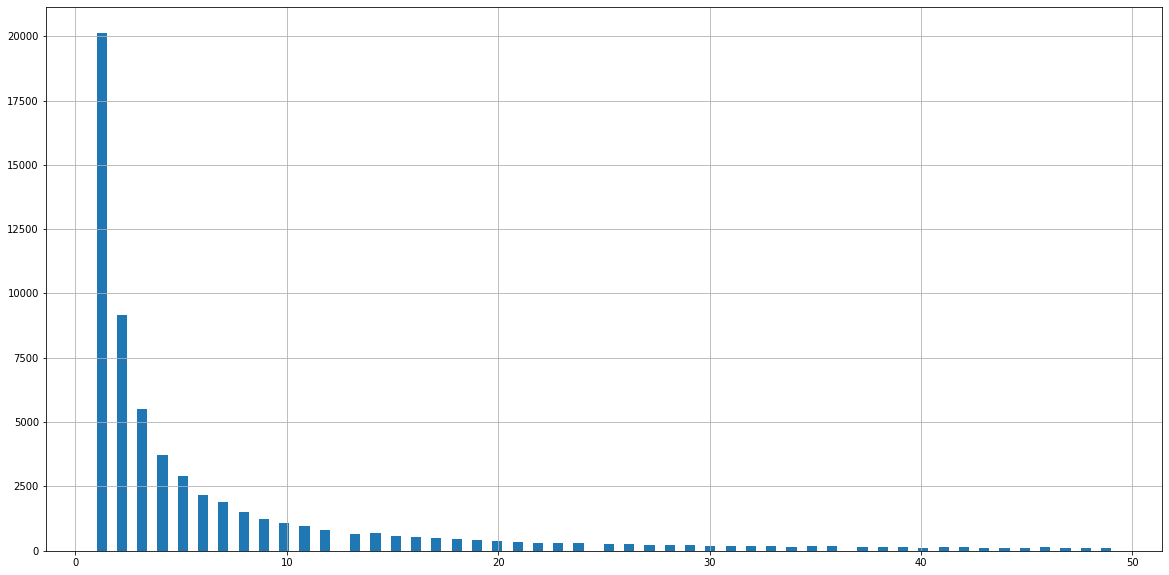

In [25]:
ds_comment_by_fan.loc[ds_comment_by_fan < 50].hist(bins = 100, figsize=(20,10))

In [26]:
print(ds_com.shape)

(1562342, 6)


In [27]:
users = ds_com[['author', 'flair']].drop_duplicates()

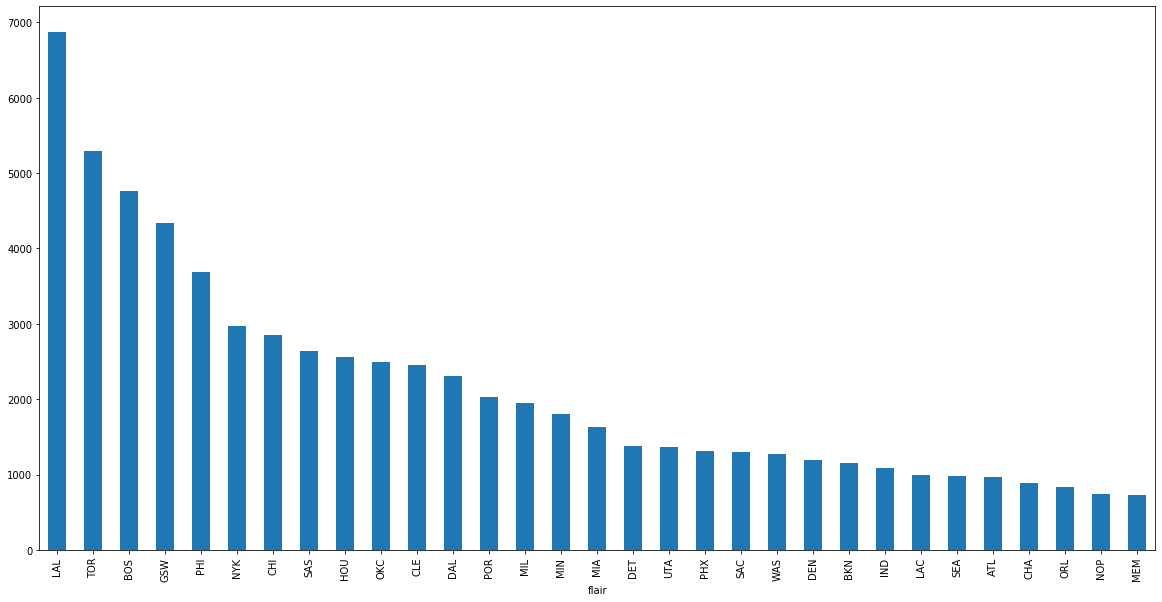

In [30]:
users.groupby('flair')['author'].count().sort_values(ascending = False).plot.bar(figsize = (20,10))

In [31]:
ds_sub_by_fan = ds_sub.groupby('author')['author'].count()

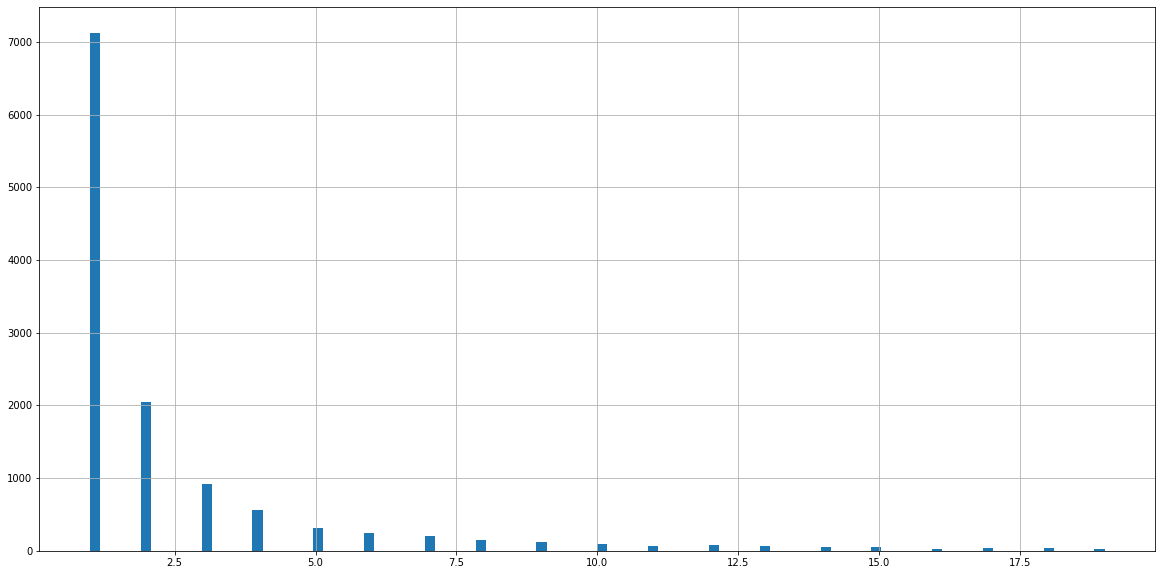

In [32]:
ds_sub_by_fan.loc[ds_sub_by_fan<20].hist(bins = 100, figsize = (20,10))

In [19]:
# put submissions and comments together
ds = pd.concat([ds_sub[['flair', 'title']].rename(columns = {'flair':'team', 'title':'text'}),
                ds_com[['flair', 'text']].rename(columns = {'flair':'team'})],
               ignore_index = True)

In [20]:
import re
import string

In [21]:
ds['text'] = ds['text'].map(lambda x: re.sub(r'((http|ftp|https):\/\/)?[\w\-_]+(\.[\w\-_]+)+([\w\-\.,@?^=%&amp;:/~\+#]*[\w\-\@?^=%&amp;/~\+#])?', ' ', str(x)))

In [22]:
def replace_punctuation(text):
    #replace punctuation with space
    no_punct = ''.join([c if c not in string.punctuation else ' ' for c in text])
    #replace special char like 🏀
    no_punct = no_punct.encode('ascii', 'ignore').decode('ascii')
    #remove \n \t \r
    return no_punct.translate(str.maketrans("\n\t\r", "   "))

In [ ]:
ds['text'] = ds['text'].apply(replace_punctuation)

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [41]:
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1, 1), stop_words='english', max_df=.6)

In [42]:
import numpy as np
from sklearn.model_selection import train_test_split

In [43]:
X_train, X_test, y_train, y_test = train_test_split(ds['text'], ds['team'], test_size=0.20, random_state=0)

In [44]:
train_raw = tfidf.fit_transform(X_train)
test_raw = tfidf.transform(X_test)

In [45]:
from sklearn.naive_bayes import MultinomialNB

In [46]:
cvec_nb = MultinomialNB()
cvec_nb.fit(train_raw, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [47]:
cvec_nb.score(train_raw, y_train)

0.2221173140027491

In [48]:
cvec_nb.score(test_raw, y_test)

0.20482501143514112

In [50]:
ds_base = ds['team'].to_frame()
ds_base['pred'] = ds_base['team'].sample(frac=1, random_state=0).reset_index(drop=True)

In [51]:
(ds_base['team'] == ds_base['pred']).mean()

0.05344053128382258

In [53]:
1/31

0.03225806451612903

In [ ]:
y_test_prob = cvec_nb.predict_proba(test_raw)

In [ ]:
y_test_prob.shape

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
enc = OneHotEncoder()
y_test_ohe = enc.fit_transform(y_test.values.reshape(-1, 1))

In [ ]:
enc.categories_

In [ ]:
cvec_nb.classes_

In [ ]:
from sklearn.metrics import roc_curve, auc

In [ ]:
n_classes = ds_base['team'].unique().shape[0]

In [ ]:
y_test_prob.shape

In [ ]:
y_test_ohe.shape

In [ ]:
y_test_ohe = y_test_ohe.toarray()

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_ohe[:, i], y_test_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_ohe.ravel(), y_test_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
roc_auc

# add game time

In [184]:
gametime = pd.read_csv('../data/game_schedule_reg18.csv',
                       names = ['date', 'time', 'visitor', 'vpts', 'home', 'hpts',
                                  'box', 'ot', 'attend', 'notes'],
                      skiprows=1).drop(['box', 'notes'], axis=1)

In [185]:
from datetime import datetime

In [186]:
form = '%a %b %d %Y %I:%M%p'
def dataplustime(ds):
    return datetime.strptime(ds['date'] + ' ' + ds['time'] + 'm', form)

In [187]:
gametime['datetime'] = gametime[['date', 'time']].apply(dataplustime, axis=1)

In [188]:
gametime.drop(['date', 'time'], axis = 1, inplace=True)

In [190]:
gametime.loc[gametime['ot'].isnull(), 'ot'] = 'NAN'

In [192]:
def count_ots(ot):
    if ot == 'NAN':
        return 0
    elif ot == 'OT':
        return 1
    else:
        return int(ot[0])

In [193]:
gametime['ot'] = gametime['ot'].apply(count_ots)

In [196]:
gametime['visitor'] = gametime['visitor'].apply(flair2team, args = [team_dict, team_fulls, team_abbrs])
gametime['home'] = gametime['home'].apply(flair2team, args = [team_dict, team_fulls, team_abbrs])

In [197]:
gametime

,visitor,vpts,home,hpts,ot,attend,datetime
0,PHI,87,BOS,105,0,18624,2018-10-16 20:00:00
1,OKC,100,GSW,108,0,19596,2018-10-16 22:30:00
2,MIL,113,CHA,112,0,17889,2018-10-17 19:00:00
3,BKN,100,DET,103,0,20332,2018-10-17 19:00:00
4,MEM,83,IND,111,0,17923,2018-10-17 19:00:00
...,...,...,...,...,...,...,...
1225,CHI,109,PHI,125,0,20197,2019-04-10 20:00:00
1226,DAL,94,SAS,105,0,18629,2019-04-10 20:00:00
1227,MIN,95,DEN,99,0,16332,2019-04-10 22:30:00
1228,UTA,137,LAC,143,1,17655,2019-04-10 22:30:00
